<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/BAF_Reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install google-colab
!pip install dask[dataframe]
!pip install pyarrow
!pip install aequitas
!pip install optuna

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/feedzai/bank-account-fraud.git

Cloning into 'bank-account-fraud'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 110 (delta 54), reused 64 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 1.13 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import yaml              # Read hyperparameter space configuration
import glob
import os
import logging
import sys

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder # Categorical encoding for LGBM models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from aequitas.group import Group                # Fairness metrics

import yaml


In [5]:
#Get the absolute path to the directory containing random_search.py
directory_path = os.path.abspath('/content/bank-account-fraud/notebooks')

# Add the directory to the Python path
sys.path.append(directory_path)

# Now you can import from random_search
from random_search import RandomValueTrial, suggest_callable_hyperparams

# Load Bank Account Fraud (BAF) Tabular Dataset Suite

use this code to create parquet files

In [6]:
'''base_path = '/content/drive/MyDrive/Mirthe Supervision Map /Paper 3a: FC Bias Disco/BAF'

# Dictionary mapping dataset names to CSV paths
datasets_paths = {
    "Base": base_path + "/Base.csv",
    "Variant I": base_path + "/Variant I.csv",
    "Variant II": base_path + "/Variant II.csv",
    "Variant III": base_path + "/Variant III.csv",
    "Variant IV": base_path + "/Variant IV.csv",
    "Variant V": base_path + "/Variant V.csv",
}

# Convert CSV files to Parquet
for variant, csv_path in datasets_paths.items():
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Create the corresponding Parquet path by replacing .csv with .parquet
    parquet_path = csv_path.replace(".csv", ".parquet")

    # Save the DataFrame as a Parquet file
    df.to_parquet(parquet_path, engine='pyarrow')

    print(f"Converted {variant} to Parquet at {parquet_path}")'''


'base_path = \'/content/drive/MyDrive/Mirthe Supervision Map /Paper 3a: FC Bias Disco/BAF\'\n\n# Dictionary mapping dataset names to CSV paths\ndatasets_paths = {\n    "Base": base_path + "/Base.csv",\n    "Variant I": base_path + "/Variant I.csv",\n    "Variant II": base_path + "/Variant II.csv",\n    "Variant III": base_path + "/Variant III.csv",\n    "Variant IV": base_path + "/Variant IV.csv",\n    "Variant V": base_path + "/Variant V.csv",\n}\n\n# Convert CSV files to Parquet\nfor variant, csv_path in datasets_paths.items():\n    # Read the CSV file into a DataFrame\n    df = pd.read_csv(csv_path)\n\n    # Create the corresponding Parquet path by replacing .csv with .parquet\n    parquet_path = csv_path.replace(".csv", ".parquet")\n\n    # Save the DataFrame as a Parquet file\n    df.to_parquet(parquet_path, engine=\'pyarrow\')\n\n    print(f"Converted {variant} to Parquet at {parquet_path}")'

In [7]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [8]:
datasets = {key: read_dataset(path) for key, path in datasets_paths.items()}

In [9]:
#dataframes["Variant I"].info()

# Find best model

5 LightGBM models with the best results (evaluation metrics accuracy or AUC) were chosen. These were trained and evaluated on the original data and involved testing 200 different sets hps (e.g., learning rate, number of leaves, max depth) that control how the model learns.
The HP configurations were chosen through random search.

In [10]:
# Read hyperparameter space for the LGBM Models, expected structure is presented bellow
with open("/content/bank-account-fraud/notebooks/lightgbm_hyperparameter_space.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [11]:
# The expected structure is the following:
hyperparam_space

{'LightGBM': {'classpath': 'lightgbm.LGBMClassifier',
  'kwargs': {'n_estimators': {'type': 'int',
    'range': [20, 10000],
    'log': True},
   'max_depth': {'type': 'int', 'range': [3, 30]},
   'learning_rate': {'type': 'float', 'range': [0.02, 0.1], 'log': True},
   'num_leaves': {'type': 'int', 'range': [10, 100], 'log': True},
   'boosting_type': ['gbdt', 'goss'],
   'min_data_in_leaf': {'type': 'int', 'range': [5, 200], 'log': True},
   'max_bin': {'type': 'int', 'range': [100, 500]},
   'enable_bundle': [True, False]}}}

In [12]:
# Testing a random search suggestion:
trial = RandomValueTrial(seed=1)
suggest_callable_hyperparams(trial, hyperparam_space)

{'classpath': 'lightgbm.LGBMClassifier',
 'n_estimators': 263,
 'max_depth': 23,
 'learning_rate': 0.020003681922217444,
 'num_leaves': 19,
 'boosting_type': 'gbdt',
 'min_data_in_leaf': 9,
 'max_bin': 238,
 'enable_bundle': False}

In [13]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [14]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs = {key: df[df["month"]>=6].sample(frac=1, replace=False) for key, df in datasets.items()}

pre-process step

In [15]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    test = test_dfs[name]

    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

In [16]:
import numpy as np
import joblib
import os
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Define number of trials in Random search (change from 100 to 10)
n_trials = 10

# Random state for sampling seeds.
np.random.seed(42)

# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}

# Define path to save the models
models_path = "saved_models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"]

    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams

    for dataset_name in datasets.keys():
        # Create and fit the model
        model = LGBMClassifier(n_jobs=10, **test_hyperparams)
        X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_train = train_dfs[dataset_name]["fraud_bool"]
        X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_test = test_dfs[dataset_name]["fraud_bool"]

        # Fit model to training data
        model.fit(X_train, y_train, categorical_feature=categorical_features)

        # Save the trained model
        model_filename = os.path.join(models_path, f"{dataset_name}_trial_{trial}_model.pkl")
        joblib.dump(model, model_filename)

        # Model predictions and metrics
        predictions = model.predict_proba(X_test)[:, 1]
        fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
        threshold = np.min(thresholds[fprs == max(fprs[fprs < 0.05])])
        recall = np.max(tprs[fprs == max(fprs[fprs < 0.05])])

        # Binarize predictions for Aequitas
        preds_binary = (predictions > threshold).astype(int)

        # Create a dataframe for evaluation
        aequitas_df = pd.DataFrame(
            {
                "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
                "preds": preds_binary,
                "y": y_test.values
            }
        )

        # Aequitas evaluation
        g = Group()
        aequitas_results = g.get_crosstabs(aequitas_df, attr_cols=["age"], score_col="preds", label_col="y")[0]

        # Store the results in a dictionary
        results = {}
        results["recall"] = recall
        results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
        results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
        results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
        results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

        # Save the metrics in the runs dictionary
        prev_runs = runs.get(dataset_name, [])
        prev_runs.append(results)
        runs[dataset_name] = prev_runs


Streaminguitvoer ingekort tot de laatste 5000 regels.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)

In [ ]:
rs_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hyperparams  10 non-null     object
 1   Base         10 non-null     object
 2   Variant I    10 non-null     object
 3   Variant II   10 non-null     object
 4   Variant III  10 non-null     object
 5   Variant IV   10 non-null     object
 6   Variant V    10 non-null     object
dtypes: object(7)
memory usage: 688.0+ bytes


In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():#iteritems():
        values.append(val[metric])
    return values

In [ ]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as higher fpr / lower fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

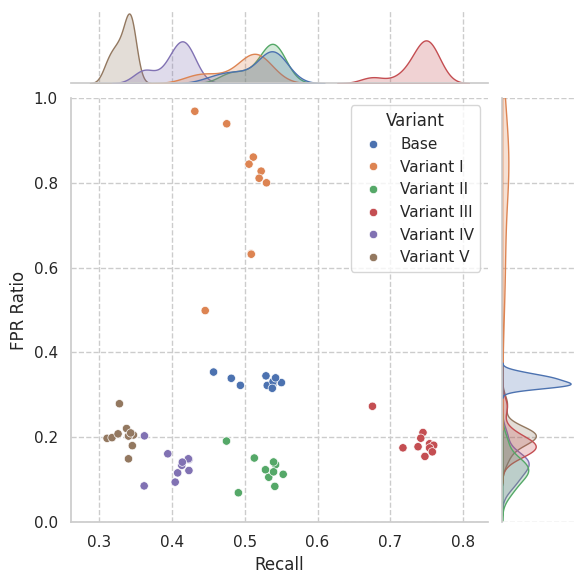

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));

In [ ]:
import copy
# Create the final plot. Highlight the top models:
top_n = 1
top_models_base = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
top_models = copy.deepcopy(top_models_base)#deepcopy(top_models_base)
for i in range(1, 6):
    top_models = np.r_[top_models, top_models_base + (100 * i)]

plot_results['index'] = plot_results.index
plot_results['is_top'] = plot_results.apply(lambda x: 1 if x['index'] in top_models else 0, axis=1)

<ipython-input-23-7f9e5eee13bd>:16: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
<ipython-input-23-7f9e5eee13bd>:17: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)


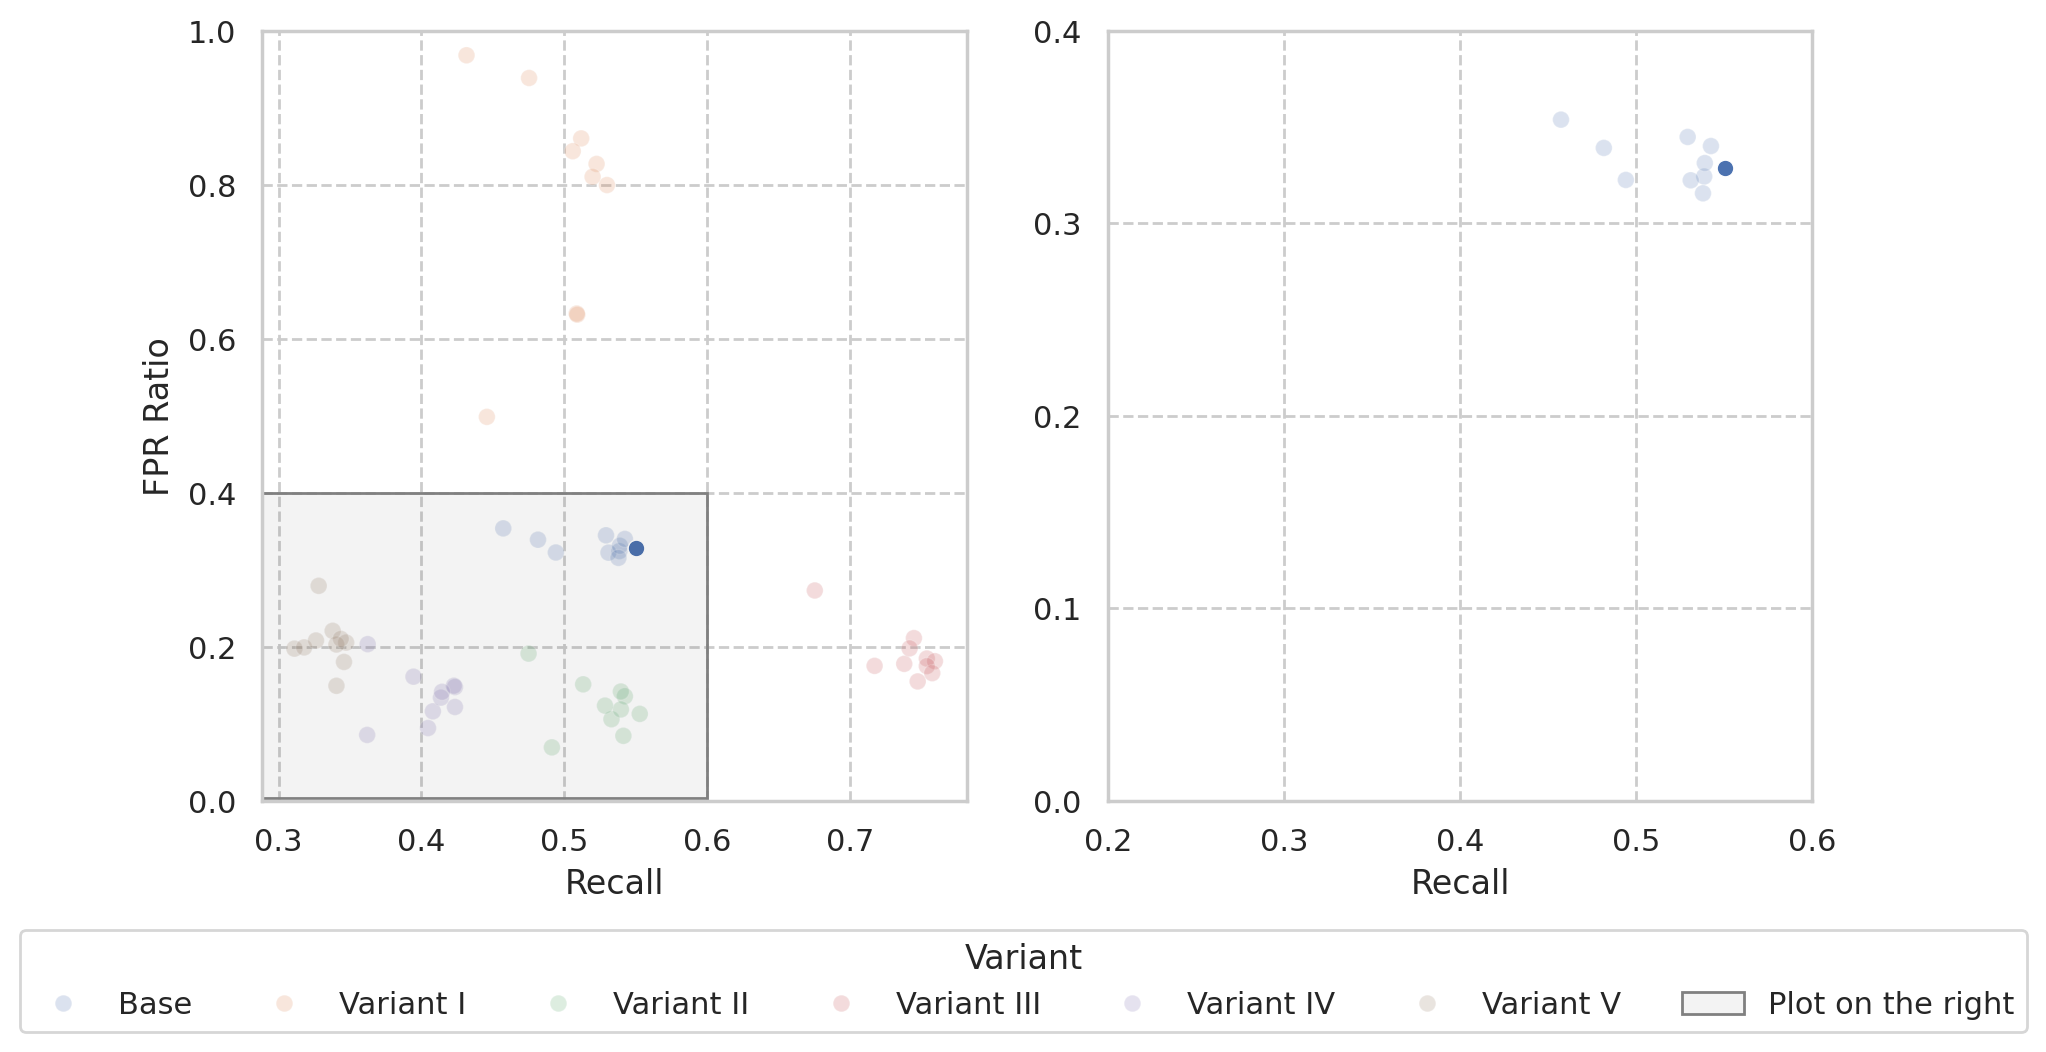

In [ ]:
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha":0.1})
DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,5)

fig, (ax1, ax2) = plt.subplots(1, 2)

# LEFT PLOT
sns.scatterplot(ax=ax1, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2)
sns.scatterplot(ax=ax1, data=plot_results.loc[plot_results.index.isin(top_models), :], x="Recall", y="FPR Ratio", hue="Variant", legend=False)
ax1.set(
    ylim=(0,1)
)

# RIGHT PLOT
sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
ax2.set(
    ylim=(0,0.4),
    ylabel="",
    xticks=np.arange(0.2, 0.8, 0.1),
    yticks=np.arange(0, 0.5, 0.1),
    xlim=(0.2, 0.6),
)

rect = plt.Rectangle((0.2, 0.004), 0.4, 0.396, facecolor=(0.1, 0.1, 0.1, 0.05), edgecolor="grey", linestyle="-")
ax1.add_patch(rect)
handles, labels = ax1.get_legend_handles_labels()
handles = list(handles) + [rect]
labels = list(labels) + ["Plot on the right"]
ax1.legend(handles, labels, title="Variant")

sns.move_legend(
    ax1,
    loc="lower center",
    bbox_to_anchor=[1.08, -0.32],
    ncol=7
)

save the best models

In [ ]:
import joblib

# Create a folder to save the models if it doesn't exist
models_path = "top_models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

# Get the variant names from the datasets
variant_names = list(datasets_paths.keys())

# Iterate over the top models and save them (assuming top_models contains model indices for top 2 models per dataset)
for idx in top_models:
    # Determine which variant this index corresponds to
    variant_index = idx // n_trials  # Assuming n_trials is the number of models per variant
    relative_idx = idx % n_trials     # Get the index within the variant (0 to n_trials-1)

    # Get the corresponding variant name
    variant_name = variant_names[variant_index]

    # Access the model from the runs dictionary
    model = runs[variant_name][relative_idx]

    # Save the model using joblib
    model_filename = os.path.join(models_path, f"model_{variant_name}_top_{relative_idx}.pkl")
    joblib.dump(model, model_filename)

print(f"Saved top models successfully in '{models_path}' directory.")


IndexError: list index out of range

In [ ]:
print("Plot results indices:", plot_results.index.tolist())
print("Top models:", top_models)

In [ ]:
# Path to the saved model
model_path = "/content/top_models/model_Variant I_4.pkl"  #

# Load the model
model = joblib.load(model_path)
